## A LSTM for 2D position estimatin  

### import packages
1- `matplotlip ` for drwaing results

2- `numpy` numerical computation

3- `Tensorflow & Keras` machine learning libraries 


In [1]:
%matplotlib inline
# %pylab osx
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling1D,UpSampling1D,Reshape,Conv1D
import scipy.io as spio
import os
import pickle
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, TimeDistributed, Bidirectional, Input,LSTM,GRU,ConvLSTM2D
from keras.utils.test_utils import keras_test
# Some additional libraries which we'll use just
# to produce some visualizations of our training

import IPython.display as ipyd
plt.style.use('ggplot')

Using TensorFlow backend.


### definition of Functions

In [2]:
###$$ GET_SPIKES_WITH_HISTORY #####
def get_spikes_with_history(neural_data,bins_before,bins_after,bins_current=1):
    """
    Function that creates the covariate matrix of neural activity

    Parameters
    ----------
    neural_data: a matrix of size "number of time bins" x "number of neurons"
        the number of spikes in each time bin for each neuron
    bins_before: integer
        How many bins of neural data prior to the output are used for decoding
    bins_after: integer
        How many bins of neural data after the output are used for decoding
    bins_current: 0 or 1, optional, default=1
        Whether to use the concurrent time bin of neural data for decoding

    Returns
    -------
    X: a matrix of size "number of total time bins" x "number of surrounding time bins used for prediction" x "number of neurons"
        For every time bin, there are the firing rates of all neurons from the specified number of time bins before (and after)
    """

    num_examples=neural_data.shape[0] #Number of total time bins we have neural data for
    num_neurons=neural_data.shape[1] #Number of neurons
    surrounding_bins=bins_before+bins_after+bins_current #Number of surrounding time bins used for prediction
    X=np.empty([num_examples,surrounding_bins,num_neurons]) #Initialize covariate matrix with NaNs
    X[:] = 0
    #Loop through each time bin, and collect the spikes occurring in surrounding time bins
    #Note that the first "bins_before" and last "bins_after" rows of X will remain filled with NaNs, since they don't get filled in below.
    #This is because, for example, we cannot collect 10 time bins of spikes before time bin 8
    start_idx=0
    for i in range(num_examples-bins_before-bins_after): #The first bins_before and last bins_after bins don't get filled in
        end_idx=start_idx+surrounding_bins; #The bins of neural data we will be including are between start_idx and end_idx (which will have length "surrounding_bins")
        X[i+bins_before,:,:]=neural_data[start_idx:end_idx,:] #Put neural data from surrounding bins in X, starting at row "bins_before"
        start_idx=start_idx+1;
    return X

In [3]:
def distance2(p0,p1):
    
    return ((p0[0] - p1[0])**2 + (p0[1] - p1[1])**2)

def distance(p0,p1):
    
    return ((p0 - p1)**2)

### import and preprocessing data
Neural data should be a matrix of size "number of time bins" x "number of neurons", where each entry is the firing rate of a given neuron in a given time bin

The output  should be a matrix of size "number of time bins" x "number of features for decoding"


In [4]:
path='MS.mat'
mat=spio.loadmat(path,squeeze_me=True)
x_data=mat['MSTrain'][:,1:63].astype('float32')
y_data=mat['MSTrain'][:,63:65].astype('float32')
bins_before=30 #How many bins of neural data prior to the output are used for decoding
bins_current=1 #Whether to use concurrent time bin of neural data
bins_after=30 #How many bins of neural data after the output are used for decoding
# Format for recurrent neural networks (SimpleRNN, GRU, LSTM)
# Function to get the covariate matrix that includes spike history from previous bins
X=get_spikes_with_history(x_data,bins_before,bins_after,bins_current)
X_train=X
  
y_data2=np.divide(y_data-np.mean(y_data,axis=0),np.std(y_data,axis=0))
y_train=y_data2
print ('Train data shape: ', X_train.shape)
print ('Train labels shape: ', y_train.shape)

Train data shape:  (23209, 61, 62)
Train labels shape:  (23209, 2)


### plot training data

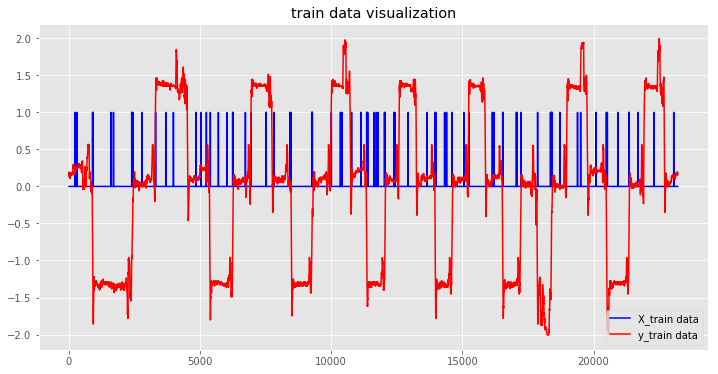

In [5]:

plt.figure(num=None, figsize=(12, 6))

plt1=plt.plot(X_train[:,0,0],'b',label="X_train data")


plt.plot(y_train[:,0],'r',label="y_train data")

plt.legend(loc=4)
plt.title('train data visualization')

### create LSTM model
in this problem we use 100 node LSTM with input Dims 61 X 62 [time step,neurons] and a full connected network 62 X 2 for  2D position prediction

the optimizer is `` RMSPROP`` with learning rate 0.0001 and ``MSE`` loss

In [6]:
 model=Sequential() #Declare model
        #Add recurrent layer
model.add(LSTM(100,input_shape=(X_train.shape[1],X_train.shape[2]),return_sequences=False,activation='tanh')) #Within recurrent layer, include dropout

model.add(Dense(X_train.shape[2]))  

model.add(Dense(y_train.shape[1]))

#Fit model (and set fitting parameters)
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
# Let's train the model using RMSprop
model.compile(loss='mse',
              optimizer=opt)

### define a name and address for saving trained model

In [7]:

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'M1U.h5'



### import pretrained network

useit wen you want test the network

In [8]:
path='saved_models/M1U.h5'

model.load_weights(path)

### train the model for 100 iterations with batch_size 512

 model.fit(X_train,y_train,epochs=100,verbose=1,batch_size=512)

### saving trained model

In [9]:
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)






Saved trained model at /home/reza/DL/BrainProject/yousefi/saved_models/M1U.h5 


### import test path data

In [10]:

x_data=mat['MSTest'][:,1:63].astype('float32')
y_data=mat['MSTest'][:,63:65].astype('float32')

# Format for recurrent neural networks (SimpleRNN, GRU, LSTM)
# Function to get the covariate matrix that includes spike history from previous bins
Xt=get_spikes_with_history(x_data,bins_before,bins_after,bins_current)

#y_data2=np.divide(y_data-np.mean(y_data,axis=0),np.std(y_data,axis=0))
X_test=Xt
y_test=y_data
print ('Test data shape: ', X_test.shape)
print ('Test labels shape: ', y_test.shape)

Test data shape:  (4095, 61, 62)
Test labels shape:  (4095, 2)


### eval the trained model on test path and rescale data to original

In [11]:
#Get predictions
y_valid_predicted_lstm=model.predict(X_test)

y_predic=y_valid_predicted_lstm*np.std(y_data,axis=0)+np.mean(y_data,axis=0)


### calculate RMSE and 2d distance for X,Y Test path

In [12]:

rmsX=np.zeros(y_test.shape[0])
rmsY=np.zeros(y_test.shape[0])
a=np.zeros(y_test.shape[0])
for i in range(y_test.shape[0]):
    rmsX[i] = np.mean(distance(y_test[i,0], y_predic[i,0]))
    rmsY[i] = np.mean(distance(y_test[i,1], y_predic[i,1]))
    a[i]=distance2(y_test[i,:], y_predic[i,:])
rmsX=np.sqrt(np.mean(rmsX))
rmsY=np.sqrt(np.mean(rmsY))
a=np.sqrt(np.mean(a))
print('RMSE Estmation X=%f'%rmsX)

print('RMSE Estmation Y=%f'%rmsY)
print('2D Distance=%f'%a)

RMSE Estmation X=12.180004
RMSE Estmation Y=9.385940
2D Distance=15.376878


### plot and save prediction Y test path

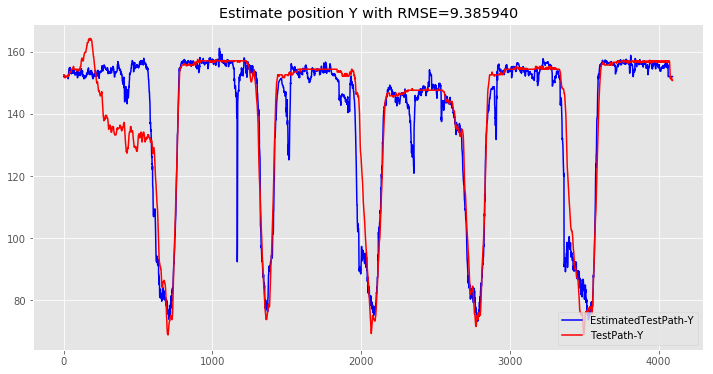

In [13]:
#As an example, I plot an example 1000 values of the x velocity (column index 0), both true and predicted with the Wiener filter
#Note that I add back in the mean value, so that both true and predicted values are in the original coordinates
plt.figure(num=None, figsize=(12, 6))

plt1=plt.plot(y_predic[:,1],'b',label="EstimatedTestPath-Y")


plt.plot(y_test[:,1],'r',label="TestPath-Y")

plt.legend(loc=4)
plt.title('Estimate position Y with RMSE=%f'%rmsY)
plt.savefig('EstimatedTestPath-Y.png',format='png', dpi=1000,transparent=False)

### plot and save prediction X Test path

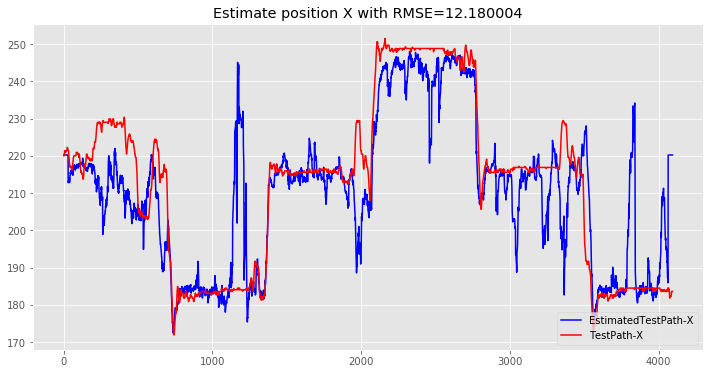

In [14]:
#As an example, I plot an example 1000 values of the x velocity (column index 0), both true and predicted with the Wiener filter
#Note that I add back in the mean value, so that both true and predicted values are in the original coordinates
plt.figure(num=None, figsize=(12, 6))

plt1=plt.plot(y_predic[:,0],'b',label="EstimatedTestPath-X")


plt.plot(y_test[:,0],'r',label="TestPath-X")

plt.legend(loc=4)
plt.title('Estimate position X with RMSE=%f'%rmsX)

#Save figure
plt.savefig('EstimatedTestPath-X.png',format='png', dpi=1000,transparent=False)

### import train path data for plot

In [15]:

x_data=mat['MSTrain'][:,1:63].astype('float32')
y_data=mat['MSTrain'][:,63:65].astype('float32')

y_train=y_data
print ('Train data shape: ', X_train.shape)
print ('Train labels shape: ', y_train.shape)
y_predic=y_valid_predicted_lstm*np.std(y_data,axis=0)+np.mean(y_data,axis=0)


Train data shape:  (23209, 61, 62)
Train labels shape:  (23209, 2)


### predict path and calculate RMSE and 2d distance for X,Y Train path

In [16]:
y_valid_predicted_lstm=model.predict(X_train)

y_predic=y_valid_predicted_lstm*np.std(y_data,axis=0)+np.mean(y_data,axis=0)
rmsX=np.zeros(y_test.shape[0])
rmsY=np.zeros(y_test.shape[0])
a=np.zeros(y_test.shape[0])
for i in range(y_test.shape[0]):
    rmsX[i] = np.mean(distance(y_train[i,0], y_predic[i,0]))
    rmsY[i] = np.mean(distance(y_train[i,1], y_predic[i,1]))
    a[i]=distance2(y_train[i,:], y_predic[i,:])
rmsX=np.sqrt(np.mean(rmsX))
rmsY=np.sqrt(np.mean(rmsY))
a=np.sqrt(np.mean(a))
print('RMSE Estmation X=%f'%rmsX)

print('RMSE Estmation Y=%f'%rmsY)
print('2D Distance=%f'%a)

RMSE Estmation X=6.316353
RMSE Estmation Y=3.542667
2D Distance=7.242017


### plot and save prediction Y Train path


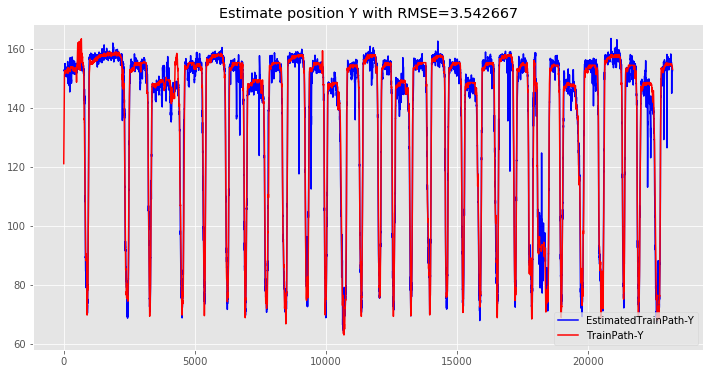

In [17]:
#As an example, I plot an example 1000 values of the x velocity (column index 0), both true and predicted with the Wiener filter
#Note that I add back in the mean value, so that both true and predicted values are in the original coordinates
plt.figure(num=None, figsize=(12, 6))

plt1=plt.plot(y_predic[:,1],'b',label="EstimatedTrainPath-Y")


plt.plot(y_train[:,1],'r',label="TrainPath-Y")

plt.legend(loc=4)
plt.title('Estimate position Y with RMSE=%f'%rmsY)
plt.savefig('EstimatedTrainPath-Y.png',format='png', dpi=1000,transparent=False)

### plot and save prediction X Train path


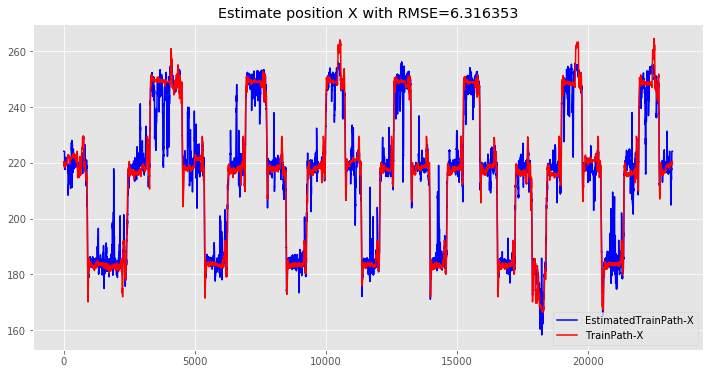

In [18]:
#As an example, I plot an example 1000 values of the x velocity (column index 0), both true and predicted with the Wiener filter
#Note that I add back in the mean value, so that both true and predicted values are in the original coordinates
plt.figure(num=None, figsize=(12, 6))

plt1=plt.plot(y_predic[:,0],'b',label="EstimatedTrainPath-X")


plt.plot(y_train[:,0],'r',label="TrainPath-X")

plt.legend(loc=4)
plt.title('Estimate position X with RMSE=%f'%rmsX)

#Save figure
plt.savefig('EstimatedTrainPath-X.png',format='png', dpi=1000,transparent=False)